In [13]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Colab Notebooks/assignment1_colab/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/assignment1_colab/assignment1/cs231n/datasets
/content/drive/My Drive/Colab Notebooks/assignment1_colab/assignment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [14]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'imp'

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [15]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

# num_color_bins = 10 # Number of bins in the color histogram
num_color_bins = 25 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train Softmax classifier on features
Using the Softmax code developed earlier in the assignment, train Softmax classifiers on top of the features extracted above; this should achieve better results than training them directly on top of raw pixels.

In [16]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import Softmax

learning_rates = [1e-7, 1e-6]
regularization_strengths = [5e5, 5e6]

results = {}
best_val = -1
best_softmax = None
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the Softmax; save#
# the best trained classifer in best_softmax. If you carefully tune the model, #
# you should be able to get accuracy of above 0.42 on the validation set.      #
################################################################################
# 遍历所有学习率和正则化强度的组合
for lr in learning_rates:
  for reg in regularization_strengths:
        # 创建Softmax分类器
        softmax_classifier = Softmax()
        # 使用当前超参数训练模型
        # 注意：这里使用特征提取后的数据X_train_feats而不是原始图像数据
        softmax_classifier.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                                num_iters=1500, verbose=False)

        # 计算训练集准确率
        y_train_pred = softmax_classifier.predict(X_train_feats)
        train_accuracy = np.mean(y_train_pred == y_train)

        # 计算验证集准确率
        y_val_pred = softmax_classifier.predict(X_val_feats)
        val_accuracy = np.mean(y_val_pred == y_val)

        # 存储结果
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # 更新最佳模型
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax_classifier

        # 打印当前结果
        print('lr %e reg %e train accuracy: %f val accuracy: %f' %
              (lr, reg, train_accuracy, val_accuracy))

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved: %f' % best_val)

lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.418571 val accuracy: 0.415000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.382857 val accuracy: 0.378000
lr 1.000000e-06 reg 5.000000e+05 train accuracy: 0.370449 val accuracy: 0.355000
lr 1.000000e-06 reg 5.000000e+06 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.418571 val accuracy: 0.415000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.382857 val accuracy: 0.378000
lr 1.000000e-06 reg 5.000000e+05 train accuracy: 0.370449 val accuracy: 0.355000
lr 1.000000e-06 reg 5.000000e+06 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved: 0.415000


In [6]:
# Evaluate your trained Softmax on the test set: you should be able to get at least 0.42
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.398


In [7]:
# Save best softmax model
best_softmax.save("best_softmax_features.npy")

best_softmax_features.npy saved.


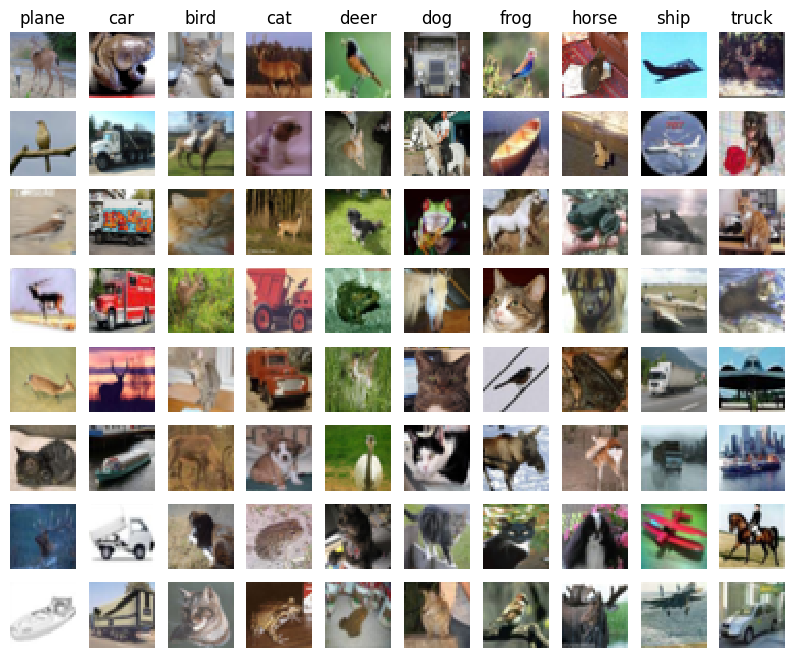

In [8]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$





## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [9]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 170)
(49000, 169)


优化的图像特征神经网络训练
输入特征维度: 169
数据集大小: 训练=49000, 验证=1000, 测试=1000

[阶段1] 学习率范围测试
--------------------------------------------------------------------------------

测试 LR=0.0020, Reg=0.01, HS=500
  验证准确率: 0.5000

测试 LR=0.0030, Reg=0.01, HS=500
  验证准确率: 0.5040

测试 LR=0.0050, Reg=0.01, HS=500
  验证准确率: 0.5420

测试 LR=0.0100, Reg=0.01, HS=500
  验证准确率: 0.5550

最佳学习率: 0.0100 (验证准确率: 0.5550)

[阶段2] 基于最佳学习率的精细调优
--------------------------------------------------------------------------------

测试 HS=500, LR=0.0100, Reg=0.005, WS=0.1, BS=128
  验证准确率: 0.5610
  <- 新的最佳!

测试 HS=600, LR=0.0100, Reg=0.01, WS=0.1, BS=128
  验证准确率: 0.5500

测试 HS=500, LR=0.0080, Reg=0.005, WS=0.1, BS=100
  验证准确率: 0.5510

测试 HS=500, LR=0.0120, Reg=0.01, WS=0.1, BS=128
  验证准确率: 0.5470

测试 HS=700, LR=0.0100, Reg=0.008, WS=0.1, BS=128
  验证准确率: 0.5580

[阶段3] 最佳配置完整训练
--------------------------------------------------------------------------------
配置: HS=500, LR=0.0100, Reg=0.005, WS=0.1, BS=128
当前最佳验证准确率: 0.5610

开始最终训练...
(Iteration 

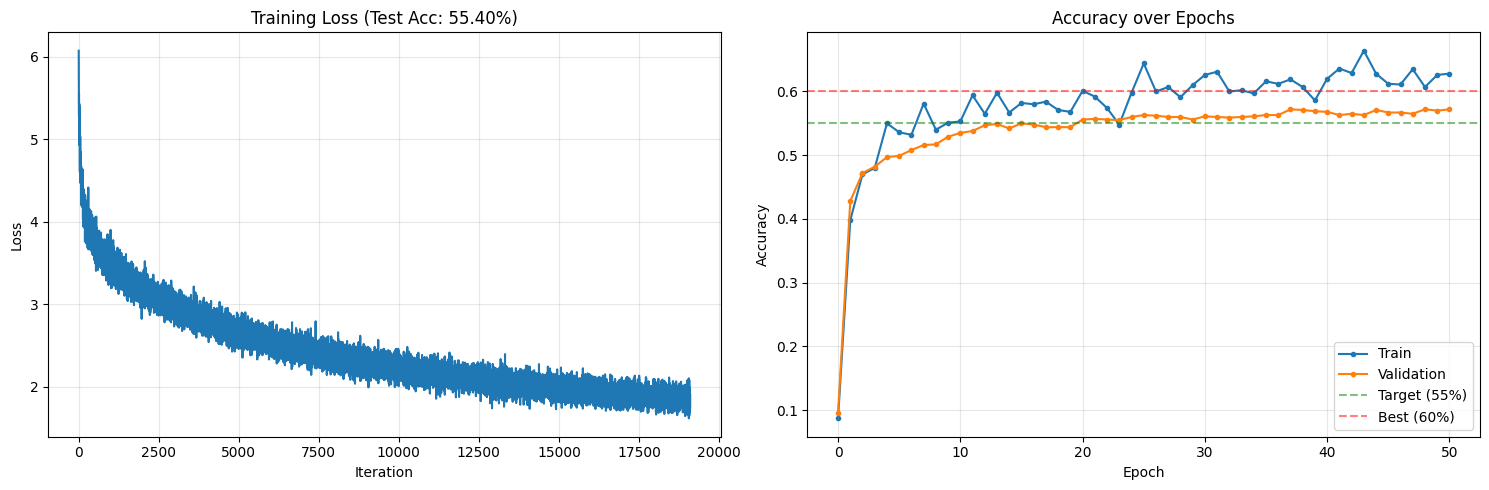

In [10]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver
import numpy as np
import matplotlib.pyplot as plt

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats,
    'y_train': y_train,
    'X_val': X_val_feats,
    'y_val': y_val,
    'X_test': X_test_feats,
    'y_test': y_test,
}

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features.                   #
################################################################################

print("=" * 80)
print("优化的图像特征神经网络训练")
print("=" * 80)
print(f"输入特征维度: {input_dim}")
print(f"数据集大小: 训练={len(y_train)}, 验证={len(y_val)}, 测试={len(y_test)}")
print("=" * 80)

# 策略：针对特征数据的优化配置
# 关键洞察：
# 1. 特征数据已经预处理过，学习率可以更高
# 2. 正则化应该更弱，因为特征本身就有正则化效果
# 3. 需要更大的模型容量
# 4. 更小的batch size以获得更好的梯度估计

# 阶段1：快速筛选最佳学习率范围
print("\n[阶段1] 学习率范围测试")
print("-" * 80)

lr_test_configs = [
    (2e-3, 0.01, 500),
    (3e-3, 0.01, 500),
    (5e-3, 0.01, 500),
    (1e-2, 0.01, 500),
]

best_val_acc = 0
lr_results = []

for lr, reg, hs in lr_test_configs:
    print(f"\n测试 LR={lr:.4f}, Reg={reg}, HS={hs}")

    net = TwoLayerNet(input_dim, hs, num_classes, weight_scale=1e-1, reg=reg)

    solver = Solver(net, data,
                   update_rule='sgd',
                   optim_config={'learning_rate': lr},
                   lr_decay=0.98,
                   num_epochs=20,
                   batch_size=128,  # 更小的batch size
                   print_every=1000,
                   verbose=False)

    solver.train()

    val_acc = solver.best_val_acc
    lr_results.append((lr, val_acc, solver))

    print(f"  验证准确率: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_net = net
        best_lr = lr

# 选择最佳学习率
lr_results.sort(key=lambda x: x[1], reverse=True)
best_lr = lr_results[0][0]

print(f"\n最佳学习率: {best_lr:.4f} (验证准确率: {lr_results[0][1]:.4f})")

# 阶段2：精细调优
print(f"\n{'='*80}")
print("[阶段2] 基于最佳学习率的精细调优")
print("-" * 80)

fine_configs = [
    # (hidden_size, learning_rate, reg, weight_scale, batch_size)
    (500, best_lr, 0.005, 1e-1, 128),
    (600, best_lr, 0.01, 1e-1, 128),
    (500, best_lr * 0.8, 0.005, 1e-1, 100),
    (500, best_lr * 1.2, 0.01, 1e-1, 128),
    (700, best_lr, 0.008, 1e-1, 128),
]

for hs, lr, reg, ws, bs in fine_configs:
    print(f"\n测试 HS={hs}, LR={lr:.4f}, Reg={reg}, WS={ws}, BS={bs}")

    net = TwoLayerNet(input_dim, hs, num_classes, weight_scale=ws, reg=reg)

    solver = Solver(net, data,
                   update_rule='sgd',
                   optim_config={'learning_rate': lr},
                   lr_decay=0.98,
                   num_epochs=20,
                   batch_size=bs,
                   print_every=1000,
                   verbose=False)

    solver.train()

    val_acc = solver.best_val_acc
    print(f"  验证准确率: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_net = net
        best_config = (hs, lr, reg, ws, bs)
        best_solver = solver
        print("  <- 新的最佳!")

# 阶段3：最终完整训练
print(f"\n{'='*80}")
print("[阶段3] 最佳配置完整训练")
print("-" * 80)

if best_val_acc > 0:
    hs, lr, reg, ws, bs = best_config
    print(f"配置: HS={hs}, LR={lr:.4f}, Reg={reg}, WS={ws}, BS={bs}")
    print(f"当前最佳验证准确率: {best_val_acc:.4f}\n")

    # 最终训练
    final_net = TwoLayerNet(input_dim, hs, num_classes, weight_scale=ws, reg=reg)

    final_solver = Solver(final_net, data,
                         update_rule='sgd',
                         optim_config={'learning_rate': lr},
                         lr_decay=0.98,
                         num_epochs=50,  # 更多轮数
                         batch_size=bs,
                         print_every=200,
                         verbose=True)

    print("开始最终训练...")
    final_solver.train()

    # 更新最佳模型
    if final_solver.best_val_acc > best_val_acc:
        best_val_acc = final_solver.best_val_acc
        best_net = final_net

    # 测试集评估
    test_acc = final_solver.check_accuracy(X_test_feats, y_test)

    print(f"\n{'='*80}")
    print("训练完成!")
    print(f"{'='*80}")
    print(f"最佳验证准确率: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
    print(f"测试集准确率: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"{'='*80}")

    # 可视化
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # 损失
    axes[0].plot(final_solver.loss_history)
    axes[0].set_title(f'Training Loss (Test Acc: {test_acc:.2%})')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True, alpha=0.3)

    # 准确率
    axes[1].plot(final_solver.train_acc_history, '-o', label='Train', markersize=3)
    axes[1].plot(final_solver.val_acc_history, '-o', label='Validation', markersize=3)
    axes[1].axhline(y=0.55, color='g', linestyle='--', alpha=0.5, label='Target (55%)')
    axes[1].axhline(y=0.60, color='r', linestyle='--', alpha=0.5, label='Best (60%)')
    axes[1].set_title('Accuracy over Epochs')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


################################################################################
#                                 END OF YOUR CODE
################################################################################

In [11]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 58% accuracy. It is also possible to get >60% accuracy
# with careful tuning.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.554


In [12]:
# Save best model
best_net.save("best_two_layer_net_features.npy")

best_two_layer_net_features.npy saved.
